In [45]:
import librosa
import numpy as np
from os import listdir
from os.path import isfile, join
from librosa import display
from sklearn.cluster import KMeans
import seaborn as sns

In [46]:
instrument_="cymbal"
mypathtrain='/Users/romainbourgeois/Desktop/malisProject/layered_data/'+instrument_+'/train/'
mypathtest='/Users/romainbourgeois/Desktop/malisProject/layered_data/'+instrument_+'/test/'

In [47]:
instrument = [f for f in listdir(mypathtrain) if isfile(join(mypathtrain, f))]
instrument2 = [f for f in listdir(mypathtest) if isfile(join(mypathtest, f))]

In [48]:
if '.DS_Store' in instrument:
    instrument.remove('.DS_Store')
if '.DS_Store' in instrument2:
    instrument2.remove('.DS_Store')
    #macs folders often contain DS_store files

data=[]
for i in range(len(instrument)):
    y, sr=librosa.load(mypathtrain+instrument[i], sr=22050, mono=True)
    data.append(y)
test=[]
for i in range(len(instrument2)):
    y, sr=librosa.load(mypathtest+instrument2[i], sr=22050, mono=True)
    test.append(y)
    
max_length=len(data[0])

In [49]:
def minmaxnorm(y):
    m=max(abs(y.min()), abs(y.max()))
    z=((y+m)/m)-1
    return z

In [50]:
def energy_cdf(y):
    y=y**2
    z=np.cumsum(y, dtype=float)/np.sum(y)
    return z

In [51]:
energy=np.zeros((len(data),max_length)) # compute energy cdf for the series
p=0
for i in data:
    energy[p]=energy_cdf(i)
    p=p+1

In [52]:
energytest=np.zeros((len(test),max_length)) 
p=0
for i in test:
    energytest[p]=energy_cdf(i)
    p=p+1

In [53]:
def plot(seconds_): # plot the value of cdf at different length
    y=energy[:,round(seconds_*22050)]
    return sns.histplot(y)

<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

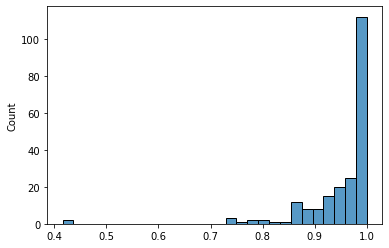

In [54]:
length=0.8
plot(length)

In [55]:
len(energy[energy[:,round(length*22050)]<0.9])/len(energy)# % of samples below 90% at length

0.1650943396226415

0.1650943396226415

In [56]:
len(energy[energy[:,round(length*22050)]<0.85])/len(energy)# % of samples below 80% at length

0.05660377358490566

0.05660377358490566

<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

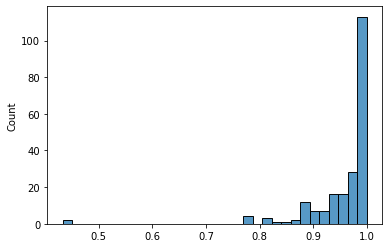

In [57]:
length=0.85
plot(length)

In [58]:
len(energy[energy[:,round(length*22050)]<0.9])/len(energy)# % of samples below 90% at length

0.1320754716981132

0.1320754716981132

In [59]:
len(energy[energy[:,round(length*22050)]<0.85])/len(energy)# % of samples below 80% at length

0.05188679245283019

0.05188679245283019

<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

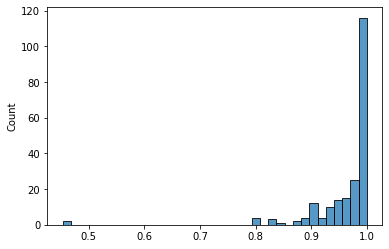

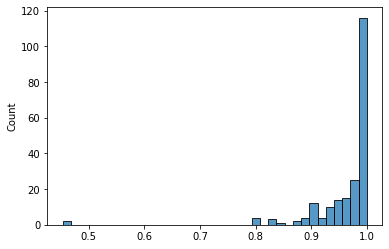

In [60]:
length=0.9
plot(length)

In [61]:
len(energy[energy[:,round(length*22050)]<0.9])/len(energy)# % of samples below 90% at length

0.08962264150943396

0.08962264150943396

In [62]:
len(energy[energy[:,round(length*22050)]<0.85])/len(energy)# % of samples below 80% at length

0.04716981132075472

0.04716981132075472

Take decision for the length

In [63]:
length=0.9
thresh=0.85 # cdf enrgy threshold under which samples are removed
ind_train=[] # index of samples to remove
ind_test=[] # index of samples to remove
l=len(instrument)
train=data
energytrain=energy
for i in range(len(energytrain)):
    if energytrain[i,round(length*22050)]<thresh:
        ind_train.append(i)
for i in range(len(energytest)):
    if energytest[i,round(length*22050)]<thresh:
        ind_test.append(i)

In [64]:
ind_train # index removed

[0, 33, 41, 61, 86, 87, 88, 90, 101, 127]

[0, 33, 41, 61, 86, 87, 88, 90, 101, 127]

In [65]:
ind_train.sort(reverse=True) # delete samples
ind_test.sort(reverse=True)
for i in ind_train:
    train=np.delete(train,i,0)
for i in ind_test:
    test=np.delete(test,i,0)
    
for i in ind_train:
    energytrain=np.delete(energytrain,i,0)
for i in ind_test:
    energytest=np.delete(energytest,i,0)

# Find maximum rate of predictions that ensure that at least all samples in the train data have an expectation to be predicted within their first cdf_threshold bound

In [66]:
sr=20050
length=length
threshold_up=0
init=0.1 # ratio of length (used to start the algo to find index cdf at cdf_target)
step=0.0005 #(ratio of length to increment the index in the algo)
cdf_target=0.75 

In [67]:
def find_thresh(datacdf, cdf_target,length,sr,threshold_up,init,step): 
    nb_points=sr*length
    upthresh_ind=round(threshold_up*nb_points)
    cdf_=[]
    for i in range(len(datacdf)):
        threshold_down=init*length 
        downthresh_ind=round(threshold_down*sr)
        cdf=datacdf[i,downthresh_ind]-datacdf[i,upthresh_ind]
        while cdf<cdf_target:
            threshold_down=threshold_down+step
            downthresh_ind=round(threshold_down*sr)
            cdf=datacdf[i,downthresh_ind]-datacdf[i,upthresh_ind]
        cdf_.append(downthresh_ind)
    return cdf_

In [68]:
trainind=find_thresh(energytrain,cdf_target=cdf_target,length=length,sr=sr,threshold_up=threshold_up,init=0.2,step=0.0005)

In [69]:
def find_R(data,cdf_,target,length,sr,threshold_up): 
    nb_points=sr*length
    upthresh_ind=round(threshold_up*nb_points)
    r_=[]
    for i in range(len(data)):
        r=1
        downthresh_ind=cdf_[i]
        diff=downthresh_ind-upthresh_ind
        base=nb_points-diff
        p=base
        p=base
        while p>target:
            p=base/r
            r=r+2
        r_.append(r)
    return r_

In [70]:
r=find_R(energytrain,cdf_=trainind,target=1.02,length=length,sr=sr,threshold_up=threshold_up)

In [71]:
import math
print(min(r), sum(r)/len(r))

3265 11087.871287128713
3265 11087.871287128713


In [72]:
#inspect minimum Rs
r.index(min(r))
ind=[]
for i in range(len(r)):
    if r[i]==min(r):
        ind.append(i)
print("nombre de minimum",len(ind))
trainind.sort(reverse=True)
trainind # inspect the difference between second sr above

nombre de minimum 1
nombre de minimum 1


[14717,
 13514,
 13273,
 13133,
 12932,
 12902,
 12852,
 12802,
 12792,
 12792,
 12782,
 12672,
 12662,
 12621,
 12581,
 12571,
 12150,
 12110,
 11669,
 11639,
 11449,
 11439,
 11418,
 11408,
 11368,
 11108,
 10957,
 10847,
 10817,
 10807,
 10657,
 10556,
 9965,
 9945,
 9925,
 9634,
 9594,
 9584,
 9554,
 9484,
 9484,
 9454,
 9454,
 9283,
 9163,
 9153,
 9103,
 9083,
 9053,
 9043,
 9002,
 8942,
 8922,
 8902,
 8772,
 8732,
 8712,
 8611,
 8551,
 8541,
 8341,
 8321,
 8311,
 8261,
 8190,
 8120,
 7629,
 7509,
 7499,
 7469,
 7459,
 7419,
 7419,
 7419,
 7398,
 7368,
 7318,
 7228,
 7158,
 7128,
 7048,
 6977,
 6947,
 6937,
 6907,
 6897,
 6887,
 6867,
 6837,
 6797,
 6747,
 6657,
 6516,
 6506,
 6496,
 6376,
 6366,
 6356,
 6356,
 6256,
 6175,
 5945,
 5935,
 5925,
 5915,
 5865,
 5865,
 5835,
 5724,
 5654,
 5584,
 5474,
 5454,
 5403,
 5343,
 5273,
 5263,
 5243,
 5223,
 5073,
 5073,
 5063,
 5013,
 4982,
 4972,
 4942,
 4842,
 4782,
 4762,
 4662,
 4601,
 4381,
 4341,
 4241,
 4150,
 4120,
 4090,
 4040,
 4

[14717,
 13514,
 13273,
 13133,
 12932,
 12902,
 12852,
 12802,
 12792,
 12792,
 12782,
 12672,
 12662,
 12621,
 12581,
 12571,
 12150,
 12110,
 11669,
 11639,
 11449,
 11439,
 11418,
 11408,
 11368,
 11108,
 10957,
 10847,
 10817,
 10807,
 10657,
 10556,
 9965,
 9945,
 9925,
 9634,
 9594,
 9584,
 9554,
 9484,
 9484,
 9454,
 9454,
 9283,
 9163,
 9153,
 9103,
 9083,
 9053,
 9043,
 9002,
 8942,
 8922,
 8902,
 8772,
 8732,
 8712,
 8611,
 8551,
 8541,
 8341,
 8321,
 8311,
 8261,
 8190,
 8120,
 7629,
 7509,
 7499,
 7469,
 7459,
 7419,
 7419,
 7419,
 7398,
 7368,
 7318,
 7228,
 7158,
 7128,
 7048,
 6977,
 6947,
 6937,
 6907,
 6897,
 6887,
 6867,
 6837,
 6797,
 6747,
 6657,
 6516,
 6506,
 6496,
 6376,
 6366,
 6356,
 6356,
 6256,
 6175,
 5945,
 5935,
 5925,
 5915,
 5865,
 5865,
 5835,
 5724,
 5654,
 5584,
 5474,
 5454,
 5403,
 5343,
 5273,
 5263,
 5243,
 5223,
 5073,
 5073,
 5063,
 5013,
 4982,
 4972,
 4942,
 4842,
 4782,
 4762,
 4662,
 4601,
 4381,
 4341,
 4241,
 4150,
 4120,
 4090,
 4040,
 4

In [73]:
for i in ind:
    print(energytrain[i,round(length*22050)]) #?

0.8706458088996211
0.8706458088996211


# Padding _train

In [74]:
to_padding=[] # save the series with their target_cdf index as sample length
for i in range(len(train)):
    s=train[i,:trainind[i]]
    to_padding.append(s)

In [75]:
t_length=round(length*sr)  # sample length of prediction for that instrument
N_oversampling=3 # generate N different paddings
dataset_train=[]
for i in range(len(train)):
    padding=t_length-trainind[i]-round(threshold_up*t_length)
    rr=np.random.randint(0, high=padding, size=N_oversampling)
    for j in rr:
        dataset_train.append(np.pad(to_padding[i], (j, padding-j), 'constant'))

In [76]:
len(dataset_train)

606

606

In [77]:
for i in range(len(dataset_train)):  # test if final outcome sizes equal length, something prints if problem
    if len(dataset_train[i])!=round(length*sr):
        print(i)

# Pad test set

For the test data, we will not generate padding based on the sample cdf_threshold index. We will infer the index on the distribution of indexes in the training data.

<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

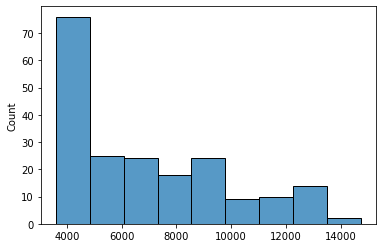

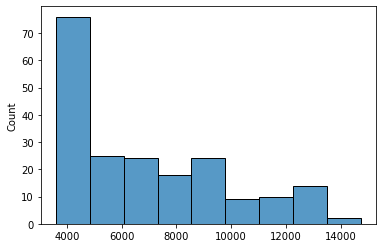

In [78]:
import seaborn as sns
from math import log
sns.histplot(trainind)

<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

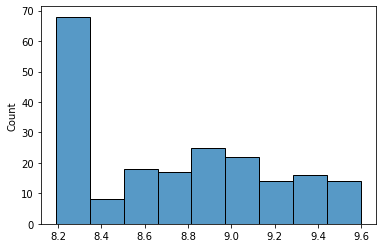

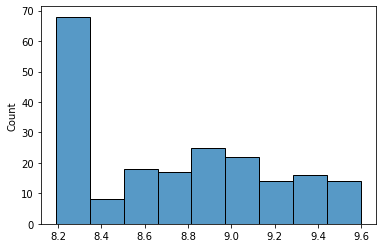

In [79]:
sns.histplot([log(x) for x in trainind])

The distribution is not normal but it is the best we got. We will hence compute its mean and std and generate indexes with a normal law.

Removing outliers:
We don't want to remove outliers on the left size, because we are sure to fit 

In [80]:
mean=np.mean(np.array([log(x) for x in trainind]))
std=np.std(np.array([log(x) for x in trainind]))

In [81]:
def remove_outliers(n,trainindex):
    if n<min([log(x) for x in trainindex]):
        n=min([log(x) for x in trainindex])
    elif n>max([log(x) for x in trainindex]):
        n=max([log(x) for x in trainindex])
    else:
        n=n
    return n

In [82]:
import math
from numpy import random
N_oversampling=3
dataset_test=[]
for i in range(len(test)):
    nn=random.normal(loc=mean, scale=std,size=1)
    for j in nn:
        j=remove_outliers(j,trainind)
        j=round(math.exp(j))
        s=test[i][:j]
        padding=t_length-j-round(threshold_up*t_length)
        rr=np.random.randint(0, high=padding, size=N_oversampling)
        for jj in rr:
            dataset_test.append(np.pad(s, (jj, padding-jj), 'constant'))

In [83]:
len(dataset_test)

171

171

In [84]:
for i in range(len(dataset_test)):  # test if final outcome sizes equal length
    if len(dataset_test[i])!=round(length*sr):
        print(i)

In [85]:
outpathtrain='/Users/romainbourgeois/Desktop/malisProject/data/'+instrument_+'/train/true'
outpathtest='/Users/romainbourgeois/Desktop/malisProject/data/'+instrument_+'/test/true'

In [86]:
import soundfile as sf
for i in range(len(dataset_train)):
    sf.write(outpathtrain+'/padded'+instrument_+str(i)+'.wav', dataset_train[i], 22050)

In [87]:
for i in range(len(dataset_test)):
    sf.write(outpathtest+'/padded'+instrument_+str(i)+'.wav', dataset_test[i], 22050)

In [89]:
R=min(r) # or other selection
r.sort()
R=r[1] # choose 2nd larger index R
minutes=3
nb_pred=3*60*sr
print(R,"-> decision for R")
print(nb_pred/R, "nb of predictions for a 3min song")
print(length,"-> length")

4445 -> decision for R
811.9235095613049 nb of predictions for a 3min song
0.9 -> length
4445 -> decision for R
811.9235095613049 nb of predictions for a 3min song
0.9 -> length
